#### Exercise 5 - Solution - Validate Difference-in-Differences Assumptions

Your company sells dog toys and cat toys (possibly among other items). Your company hired a professional photographer who overhauled the product photos for dog toys. Starting on Oct 1 2024, all customers reaching the website and observing the dog toy products observed the new photos. 

Three months later, you are tasked to evaluate the impact of the professional photos on revenue to determine if it is worth making the investment for additional products. 

We have generated time series panel data for monthly revenue from dog toys and cat toys throughout 2023 and 2024. Revenue is driven by a baseline (separate for each product), seasonality, a general holiday season bump, a 'ground truth' effect for the professional photos, and random noise. 

The benefit of generating data this way is that we know what the true effect is and we can test how well the model performs under various circumstances.

In [14]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf 
import seaborn as sns
import matplotlib.pyplot as plt

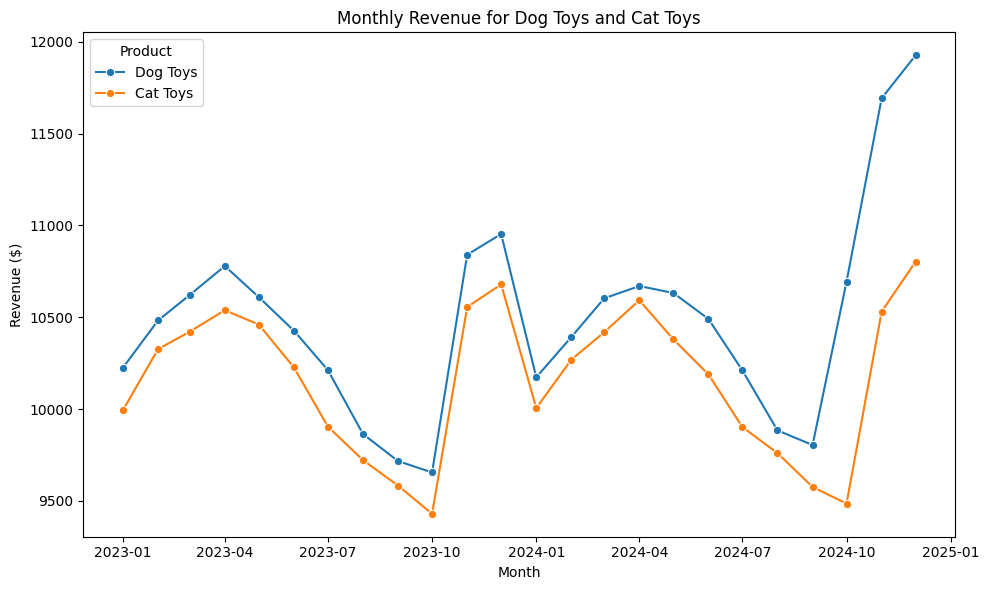

In [15]:
# Set random seed for reproducibility
np.random.seed(42)

# Parameters
n_months = 24
products = ["Dog Toys", "Cat Toys"]
months = pd.date_range(start="2023-01-01", periods=n_months, freq='MS')

# Marketing event date
event_date = pd.to_datetime('2024-10-01')
model_start_date = '2024-01-01'
model_end_date = '2025-01-01' 


# Create base dataframe
df = pd.DataFrame([(month, product) for month in months for product in products],
                  columns=["Month", "Product"])

# Add month number for seasonality
df["Month_Num"] = df["Month"].dt.month

# Seasonality: smooth wave + December holiday bump
df["Seasonality"] = 500 * np.sin((df["Month_Num"] - 1) / 12 * 2 * np.pi)
df["HolidayBump"] = np.where(df["Month_Num"] >= 11, 1000, 0)

# Add randomness and slight product-level difference
df["BaseRevenue"] = 10000
df["ProductGapBaseline"] = df["Product"].map({"Dog Toys": 200, "Cat Toys": 0})
df["Noise"] = np.random.normal(0, 50, size=len(df))


#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%%%%  This is the ground-truth effect of the treatment: 
#%%%%%  an extra $1000 monthly revenue for dog toys in Q4 2024 
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

df['BetterPhotos'] = np.where((df['Product']=='Dog Toys') & (df['Month'] >= event_date), 1000, 0)

# Final revenue
df["Revenue"] = (
    df["BaseRevenue"]
    + df["ProductGapBaseline"]
    + df["Seasonality"]
    + df["HolidayBump"]
    + df["BetterPhotos"]
    + df["Noise"]
)

# Visualize the time series
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="Month", y="Revenue", hue="Product", marker="o")
plt.title("Monthly Revenue for Dog Toys and Cat Toys")
plt.ylabel("Revenue ($)")
plt.tight_layout()
plt.show()

# Final output DataFrame
df = df[["Month", "Product", "Revenue"]]

#### Test the parallel trends assumption

One of the critical assumptions of the difference-in-differences model is that the treatment and comparison group will trend together before and throughout the experiment and measurement window. While we cannot observe this directly, we can at least check whether the two time series trended together over a period leading up to the treatment. 

Specifically, check if there is a statistically significant difference in the trends prior to the event date.

In [16]:
# Apply trend for both the treated and comparison group

subset = df[df['Month'] < event_date].copy()

subset['trend'] = (
    subset['Month'].dt.to_period('M') - pd.to_datetime(event_date).to_period('M')
).apply(lambda x: x.n)

subset['treated'] = subset['Product'].apply(lambda x: 1 if x=='Dog Toys' else 0)
subset['treated_trend'] = subset['treated'] * subset['trend']

formula = 'Revenue ~ treated + trend + treated_trend'
model = smf.ols(formula, data=subset).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     1.431
Date:                Sun, 15 Jun 2025   Prob (F-statistic):              0.249
Time:                        13:58:15   Log-Likelihood:                -307.28
No. Observations:                  42   AIC:                             622.6
Df Residuals:                      38   BIC:                             629.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.001e+04    173.195     57.824

In [17]:
# What is the estimated difference in trends? Is it statistically significant? 
print(f"Estimated Difference in Trends: {model.params['treated_trend']:.2f}")
print(f"P-value: {model.pvalues['treated_trend']:.2f}")

Estimated Difference in Trends: 0.71
P-value: 0.97
